In [1]:
import requests
import pandas as pd
import numpy as np

Link para solicitar token: https://www.banxico.org.mx/SieAPIRest/service/v1/token

In [2]:
token = '8ffecdc086d33fe006072c68d092316481e486cf476af47c8831437061f707c6'

In [3]:
def descargar_serie(serie, fechainicio, fechafin, token):
  url = 'http://www.banxico.org.mx/SieAPIRest/service/v1/series/'+serie+'/datos/'+fechainicio+'/'+fechafin
  print(url)
  headers = {'Bmx-Token':token}
  response = requests.get(url, headers=headers)
  status = response.status_code
  if status != 200:
    return print('Error en la consulta, codigo {}'.format(status))
  raw_data = response.json()
  data = raw_data['bmx']['series'][0]['datos']
  df = pd.DataFrame(data)
  df['dato'] = df['dato'].astype('float')
  df['fecha'] = pd.to_datetime(df['fecha'], format = '%d/%m/%Y')
  df.set_index('fecha', inplace=True)
  return df


## Titulo: Tipo de cambio pesos por dólar E.U.A

Serie: SF60653

Periocidad: Diaria

In [4]:
CAMBIO_PESO_DOLAR_DIARIO = descargar_serie('SF60653','1995-04-04', '2024-12-10', token)

http://www.banxico.org.mx/SieAPIRest/service/v1/series/SF60653/datos/1995-04-04/2024-12-10


In [5]:
CAMBIO_PESO_DOLAR_DIARIO.shape

(10844, 1)

## Titulo: Valor de UDIS

Serie: SP68257

Periocidad: Diaria

In [6]:
UDIS_DIARIO = descargar_serie('SP68257','1995-04-04', '2024-12-10', token)

http://www.banxico.org.mx/SieAPIRest/service/v1/series/SP68257/datos/1995-04-04/2024-12-10


In [7]:
UDIS_DIARIO.shape

(10844, 1)

<Axes: xlabel='fecha'>

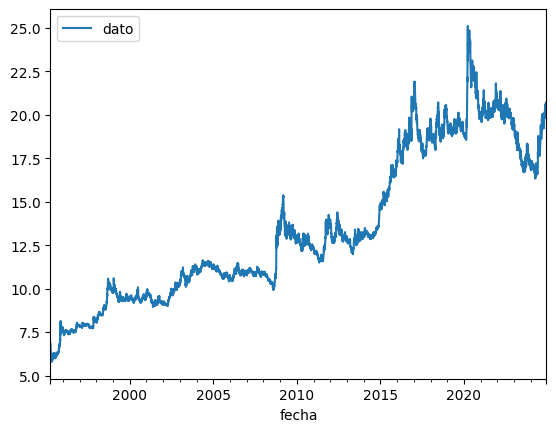

In [8]:
CAMBIO_PESO_DOLAR_DIARIO.plot(kind='line')

<Axes: xlabel='fecha'>

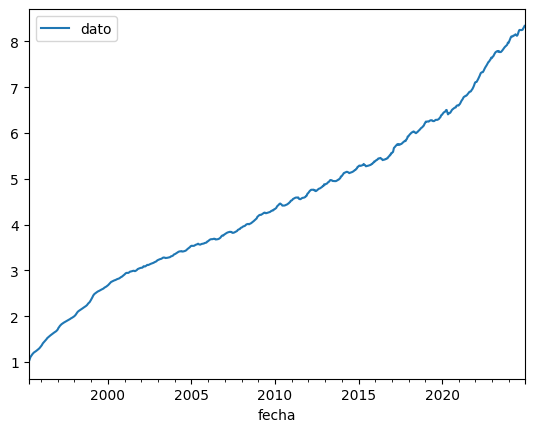

In [9]:
UDIS_DIARIO.plot(kind='line')

Para hacer los datos comparables, normalizamos los valores iniciales de ambas series. Esto se logra estableciendo un punto de referencia común, por ejemplo, escalándolos a 1 al inicio del periodo de análisis y en meses posteriores, los valores de ambos activos se calcularán de forma relativa a este inicio tambien.

Fórmula para normalizar:

$$
\text{Valor normalizado} = \frac{\text{Valor actual}}{\text{Valor inicial}}
$$


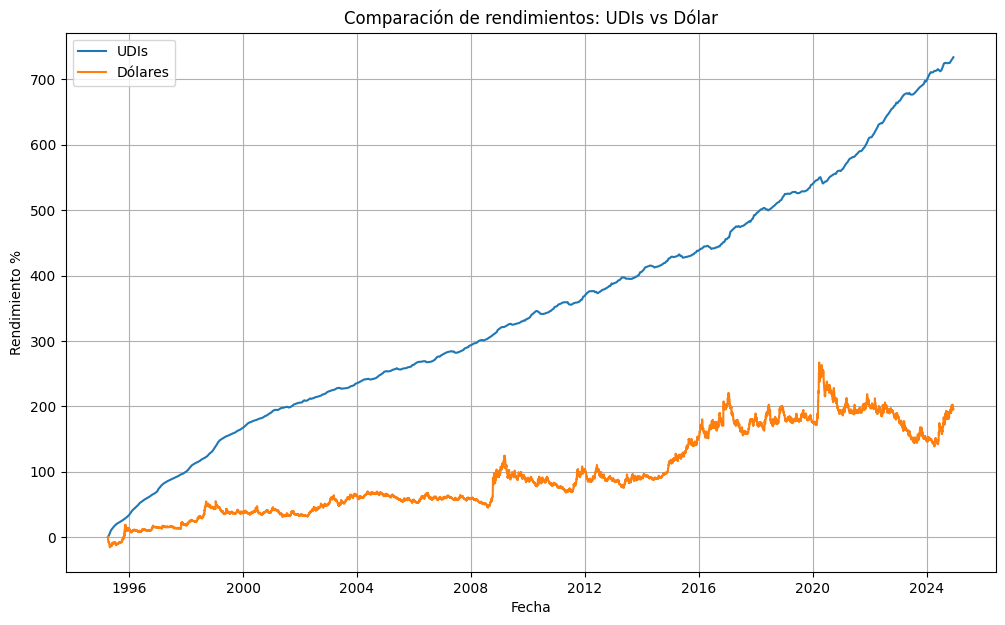

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# Datos obtenidos de la BANXICO usando la API
fechas = UDIS_DIARIO.index.to_list()
udis = UDIS_DIARIO['dato'].to_list()
dolares = CAMBIO_PESO_DOLAR_DIARIO['dato'].to_list()

# Normalización
udis_normalizados = [((x / udis[0])-1)*100 for x in udis]
dolares_normalizados = [((x / dolares[0])-1)*100 for x in dolares]

# DataFrame
data = pd.DataFrame({
    'Fecha': fechas,
    'UDIs': udis_normalizados,
    'Dólares': dolares_normalizados
})

# Gráfica
plt.figure(figsize=(12, 7))
plt.plot(data['Fecha'], data['UDIs'], label='UDIs')#, marker='.')
plt.plot(data['Fecha'], data['Dólares'], label='Dólares')#, marker='.')
plt.title('Comparación de rendimientos: UDIs vs Dólar')
plt.xlabel('Fecha')
plt.ylabel('Rendimiento %')
plt.legend()
plt.grid()
plt.show()


Calculando el rendimiento relativo de cada activo respecto a su valor inicial.
Fórmula del rendimiento porcentual:

$$
\text{Rendimiento (\%)} = \left( \frac{\text{Valor actual} - \text{Valor inicial}}{\text{Valor inicial}} \right) \times 100
$$

In [26]:
(( UDIS_DIARIO.loc['2012-01-01','dato'] - UDIS_DIARIO.loc['2000-01-01','dato'] )/UDIS_DIARIO.loc['2000-01-01','dato'])*100 

75.62109999797913

In [27]:
(( CAMBIO_PESO_DOLAR_DIARIO.loc['2012-01-01','dato'] - CAMBIO_PESO_DOLAR_DIARIO.loc['2000-01-01','dato'] )/CAMBIO_PESO_DOLAR_DIARIO.loc['2000-01-01','dato'])*100 # '1995-04-04', '2024-12-10'

46.801159395937916

In [28]:
UDIS_DIARIO.loc['2000-01-01','dato']

2.672114

In [29]:
UDIS_DIARIO.loc['2012-01-01','dato']

4.692796

In [30]:
CAMBIO_PESO_DOLAR_DIARIO.loc['2000-01-01','dato'] 

9.5222

In [31]:
CAMBIO_PESO_DOLAR_DIARIO.loc['2012-01-01','dato'] 

13.9787

In [32]:
max(udis)

8.338061

In [33]:
min(udis)

1.0

In [34]:
CAMBIO_PESO_DOLAR_DIARIO['dato'].tail()

fecha
2024-12-06    20.2830
2024-12-07    20.1963
2024-12-08    20.1963
2024-12-09    20.1963
2024-12-10    20.2275
Name: dato, dtype: float64

In [35]:
CAMBIO_PESO_DOLAR_DIARIO['dato'].head()

fecha
1995-04-04    6.8475
1995-04-05    6.8025
1995-04-06    6.5883
1995-04-07    6.4850
1995-04-08    6.3808
Name: dato, dtype: float64

Normalización de los datos:

¿Por qué normalizar? Al iniciar en diferentes valores (5 pesos para el dólar y 1 peso para la UDI), una simple comparación de los valores absolutos podría ser engañosa. Normalizar te permitirá comparar el crecimiento porcentual de ambos a partir de un punto de referencia común.
Cómo hacerlo:
Índice: Elige un año base (por ejemplo, 1994) y asigna el valor de 100 a ese año para ambas series. Luego, calcula el índice para cada año posterior dividiendo el valor de ese año entre el valor del año base y multiplicando por 100. Esto te dará una serie de índices que muestran el crecimiento porcentual relativo a partir del año base.

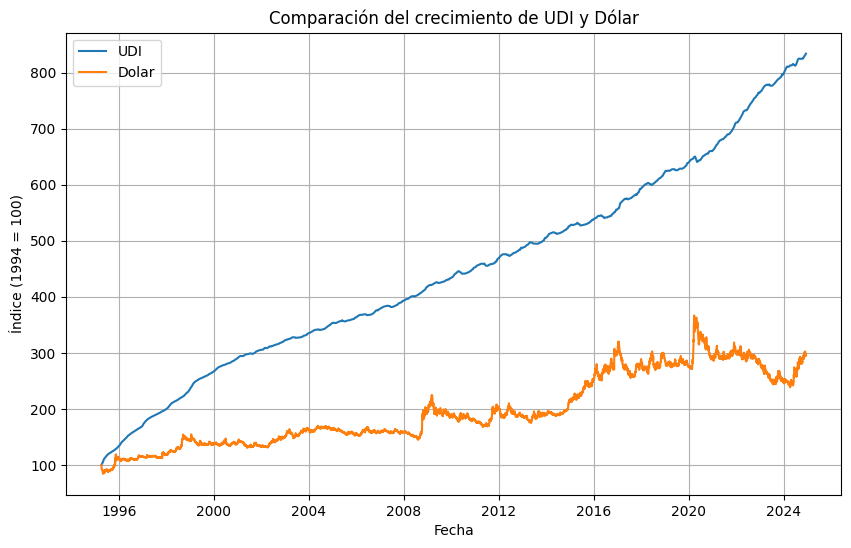

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar los datos desde el archivo CSV
# data = pd.read_csv('datos_udi_dolar.csv')

data = pd.DataFrame({
    'Fecha': fechas,
    'UDIs': udis_normalizados,
    'Dolares': dolares_normalizados
})

# Establecer el año 1994 como año base y crear un índice
data['Indice_UDI'] = data['UDIs'] / data.loc[data['Fecha'] == '1995-04-04', 'UDIs'].values[0] * 100
data['Indice_Dolar'] = data['Dolares'] / data.loc[data['Fecha'] == '1995-04-04', 'Dolares'].values[0] * 100

# Crear la gráfica
plt.figure(figsize=(10, 6))
plt.plot(data['Fecha'], data['Indice_UDI'], label='UDI')
plt.plot(data['Fecha'], data['Indice_Dolar'], label='Dolar')
plt.xlabel('Fecha')
plt.ylabel('Índice (1994 = 100)')
plt.title('Comparación del crecimiento de UDI y Dólar')
plt.legend()
plt.grid(True)
plt.show()


Crear índices: Creamos dos nuevas columnas, "Indice_UDI" e "Indice_Dolar", donde normalizamos los valores de cada año con respecto al año 1994 (tomado como referencia)

Aplicación en tu análisis
Si normalizas tanto el UDI como el dólar usando esta fórmula, puedes comparar fácilmente sus rendimientos relativos en el tiempo:

Valores positivos indican ganancias.
Valores negativos indican pérdidas.
Al graficarlos, podrás ver cuál ha dado más rendimiento a lo largo del tiempo.

Ventaja de esta fórmula
Te da directamente la variación porcentual en notación decimal (por ejemplo, 0.2 = 20%, -0.1 = -10%).
Es útil para comparar rendimientos entre diferentes activos o periodos, como en tu análisis entre UDIs y dólares.

Es un enfoque directo para medir rendimiento o cambio respecto al valor base (valor inicial).